In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):

        super(BasicBlock, self).__init__()
        self.drop = drop
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out



def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):
    
    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True)

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class ResNet(nn.Module):
    def __init__(
            self,
            block,
            num_blocks,
            conv_kernel_sizes=None,
            shortcut_kernel_sizes=None,
            num_classes=10,
            num_channels=32,
            avg_pool_kernel_size=4,
            drop=None,
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))

        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels)

        self.drop = drop
        self.squeeze_and_excitation = squeeze_and_excitation

        if self.squeeze_and_excitation:
            self.seblock = SEBlock(channels=self.num_channels)

        self.residual_layers = []
        for n in range(len(num_blocks)):
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers
            self.residual_layers.append(self._make_layer(
                                                    block,
                                                    self.num_channels*(2**n),
                                                    num_blocks[n],
                                                    stride=stride,
                                                    conv_kernel_size=conv_kernel_size,
                                                    shortcut_kernel_size=shortcut_kernel_size))

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes)

        if self.drop:
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out)
        for layer in self.residual_layers:
            out = layer(out)

        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out


def project1_model(config=None):

    net =  ResNet(
            block=BasicBlock,
            num_blocks=[4, 4, 3],                        
            conv_kernel_sizes=[3, 3, 3],          
            shortcut_kernel_sizes=[1, 1, 1] ,    
            num_channels=64,                 
            avg_pool_kernel_size=8,      
            drop=0,                      
            squeeze_and_excitation=1   
        )

    total_params = 0
    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    return net, total_params

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
def get_model():
    net, total_params = project1_model()
    net = net.to(device)
    print(f"Total number of parameters: {total_params}")
    return net


model = get_model()

Using device: cuda
Total number of params 4697742
Total layers 28
Total number of parameters: 4697742


In [7]:
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import torch
import warnings

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        self.defaults = optimizer.defaults
        for group in self.param_groups:
            group["counter"] = 0

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

In [8]:
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F, torch.backends.cudnn as cudnn
import torchvision, torchvision.transforms as transforms
import os, yaml, math, numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
==> Building model..
Total number of params 4697742
Total layers 28

Epoch: 1/400
Train Loss: 1.4920, Train Acc: 45.04%
Test Loss: 1.3381, Test Acc: 52.59%
Saving best model..

Epoch: 2/400
Train Loss: 1.0479, Train Acc: 62.52%
Test Loss: 1.0803, Test Acc: 62.41%
Saving best model..

Epoch: 3/400
Train Loss: 0.8579, Train Acc: 69.90%
Test Loss: 0.8401, Test Acc: 70.72%
Saving best model..

Epoch: 4/400
Train Loss: 0.7327, Train Acc: 75.07%
Test Loss: 0.8942, Test Acc: 68.21%

Epoch: 5/400
Train Loss: 0.6570, Train Acc: 78.35%
Test Loss: 0.7166, Test Acc: 75.78%
Saving best model..

Epoch: 6/400
Train Loss: 0.6074, Train Acc: 80.50%
Test Loss: 0.8844, Test Acc: 70.26%

Epoch: 7/400
Train Loss: 0.5823, Train Acc: 81.49%
Test Loss: 0.7241, Test Acc: 75.72%

Epoch: 8/400
Train Loss: 0.5630, Train Acc: 82.74%
Test Loss: 0.8659, Test Acc: 71.21%

Epoch: 9/400
Train Loss: 0.5545, Train Acc: 83.31%
Test Loss: 0.7962, T

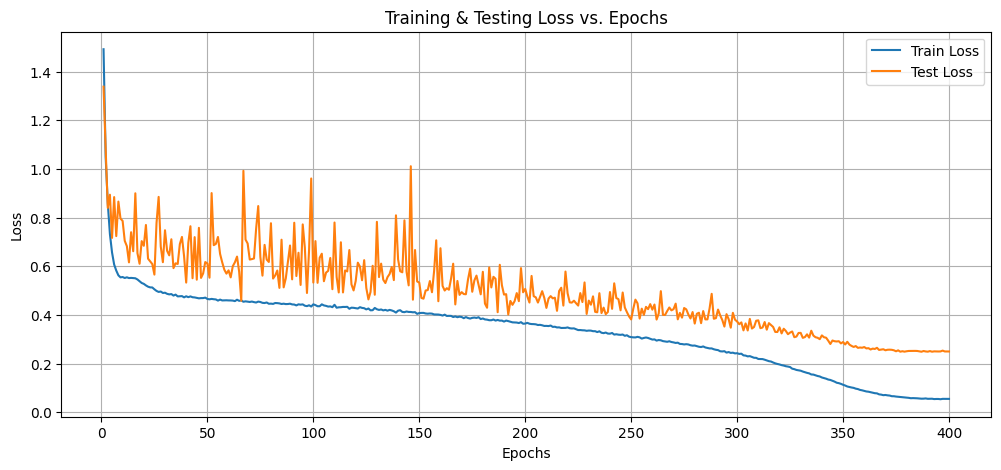

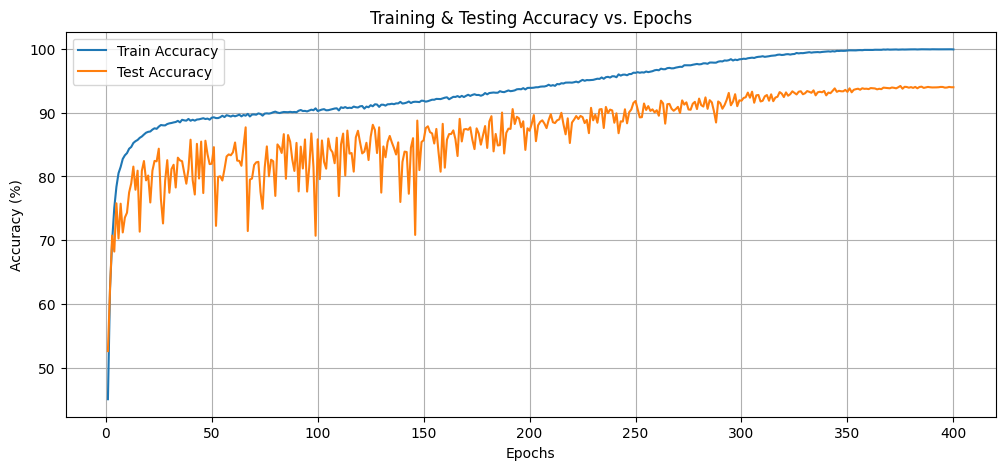

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import yaml
import matplotlib.pyplot as plt

save_path = "Model"
os.makedirs(save_path, exist_ok=True)
model_save_path = os.path.join(save_path, "best_model_final.pth")

config_path = "config.yaml"
try:
    with open(config_path, "r") as stream:
        config = yaml.safe_load(stream)["best_model"]
except (yaml.YAMLError, KeyError) as exc:
    print(f"Error loading config: {exc}")
    exit(1)

device = "cuda" if torch.cuda.is_available() else "cpu"


train_trans = [transforms.ToTensor()]
test_trans = [transforms.ToTensor()]
if config.get("data_augmentation", False):
    train_trans += [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]
if config.get("data_normalize", False):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    train_trans.append(transforms.Normalize(mean, std))
    test_trans.append(transforms.Normalize(mean, std))

transform_train = transforms.Compose(train_trans)
transform_test = transforms.Compose(test_trans)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.get("batch_size", 128), shuffle=True,num_workers=config.get("num_workers", 4))

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.get("batch_size", 128)//4, shuffle=False, num_workers=4)

print("==> Building model..")
net, total_params = project1_model(config=config)
config["total_params"] = total_params
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config.get("lr", 0.1), momentum=config.get("momentum", 0.9), weight_decay=config.get("weight_decay", 5e-4), nesterov=True)
Lookahead(optimizer, k=5, alpha=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.get("max_epochs", 400))


train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


best_acc = 0
for epoch in range(config.get("max_epochs", 400)):
    print(f"\nEpoch: {epoch+1}/{config.get('max_epochs', 400)}")
    net.train()
    train_loss, correct, total = 0, 0, 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        if config.get("grad_clip", None):
            nn.utils.clip_grad_norm_(net.parameters(), config["grad_clip"])

        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100.0 * correct / total
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss / len(trainloader):.4f}, Train Acc: {train_acc:.2f}%")

    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_acc = 100.0 * correct / total
    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(test_acc)

    print(f"Test Loss: {test_loss / len(testloader):.4f}, Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        print("Saving best model..")
        state = {
            "model_state": net.state_dict(),  # Saved with original keys
            "config": config
        }
        torch.save(state, model_save_path)
        best_acc = test_acc

    scheduler.step()

print("Training complete.")

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss vs. Epochs")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Testing Accuracy vs. Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import torch
import pickle
import pandas as pd
import torchvision.transforms as transforms

model_path = "Model/best_model_final.pth"  # Ensure this path matches your saved model
pickle_file = "Inference/cifar_test_nolabel.pkl"  # Ensure this path is correct
output_csv = "Inference/cifar10_predictions_final.csv"  # Output file for predictions


device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Ensure the checkpoint contains the required keys
if "model_state" not in checkpoint or "config" not in checkpoint:
    raise KeyError("Checkpoint does not contain 'model_state' or 'config'. Ensure you are using the correct file.")


config = checkpoint["config"]
state_dict = checkpoint["model_state"]


net, _ = project1_model(config=config)  # Ensure same architecture
net.load_state_dict(state_dict)  # Load trained weights
net.to(device)
net.eval()  # Set to evaluation mode to prevent batch norm/dropout issues
print("Model loaded successfully.")


mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.Normalize(mean, std)  # Ensure the same normalization as training
])


print("Loading test data...")
with open(pickle_file, "rb") as f:
    test_data = pickle.load(f)

# Extract test images and IDs
images = torch.tensor(test_data[b"data"], dtype=torch.float32) / 255.0  # Normalize to [0,1] range
ids = test_data[b"ids"]  # Unique IDs for each test sample

# Apply normalization transformation
images = transform(images.permute(0, 3, 1, 2))  # Convert to (N, C, H, W)
images = images.to(device)


print("Running inference on test data...")
predictions = []
with torch.no_grad():
    outputs = net(images)  # Forward pass
    _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
    predictions = predicted.cpu().numpy()  # Move results to CPU for saving


df = pd.DataFrame({"ID": ids, "Labels": predictions})
df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv} with {len(df)} rows.")

Total number of params 4697742
Total layers 28
Model loaded successfully.
Loading test data...
Running inference on test data...
Predictions saved to Inference/cifar10_predictions_final.csv with 10000 rows.
